In [1]:
# =========================
# STEP 0: Imports & Config
# =========================
import os, math, time, copy, gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# ---- Config (keep BS=32) ----
BATCH_SIZE = 32
EPOCHS_PRETRAIN = 100     # you can start with 50; 100 is better
EPOCHS_LINEAR_EVAL = 100
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-6
PROJECTION_DIM = 256
HIDDEN_DIM = 4096
MOMENTUM_BASE = 0.99
NUM_WORKERS = 2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "/kaggle/working/byol_results"
os.makedirs(SAVE_DIR, exist_ok=True)

train_path = "/kaggle/input/eurosat-dataset/EuroSAT"
test_path  = "/kaggle/input/eurosat-dataset/EuroSAT"   # EuroSAT often has no split; using same dir is fine
print("Device:", DEVICE)


Device: cuda


In [2]:
# ===========================================
# STEP 1: BYOL Transforms + Pretrain DataLoader
# ===========================================
class CustomBYOLTransform:
    def __init__(self, size=64):
        normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])
        base = transforms.Compose([
            transforms.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([transforms.GaussianBlur(3)], p=0.5),
            transforms.ToTensor(),              # critical so tensors have .to()
            normalize
        ])
        self.t1 = base
        self.t2 = base

    def __call__(self, x):
        return self.t1(x), self.t2(x)

train_dataset_byol = datasets.ImageFolder(root=train_path, transform=CustomBYOLTransform())
train_loader_byol = DataLoader(
    train_dataset_byol, batch_size=BATCH_SIZE, shuffle=True,
    drop_last=True, num_workers=NUM_WORKERS
)
print("BYOL pretrain samples:", len(train_dataset_byol))


BYOL pretrain samples: 27000


In [3]:
# =================================
# STEP 2: Model: Encoder + BYOL
# =================================
class BYOLResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet50(pretrained=False)
        base.fc = nn.Identity()
        self.encoder = base
        self.feature_dim = 2048

    def forward(self, x):
        return self.encoder(x)

class MLPHead(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x):
        return self.net(x)

class BYOL(nn.Module):
    def __init__(self, encoder, proj_dim, hidden_dim):
        super().__init__()
        self.online_encoder   = encoder
        self.online_projector = MLPHead(encoder.feature_dim, hidden_dim, proj_dim)
        self.online_predictor = MLPHead(proj_dim, hidden_dim, proj_dim)

        self.target_encoder   = copy.deepcopy(self.online_encoder)
        self.target_projector = copy.deepcopy(self.online_projector)
        for p in self.target_encoder.parameters(): p.requires_grad = False
        for p in self.target_projector.parameters(): p.requires_grad = False

    def forward(self, x1, x2):
        z1 = self.online_projector(self.online_encoder(x1)); p1 = self.online_predictor(z1)
        z2 = self.online_projector(self.online_encoder(x2)); p2 = self.online_predictor(z2)
        with torch.no_grad():
            t1 = self.target_projector(self.target_encoder(x1))
            t2 = self.target_projector(self.target_encoder(x2))
        return p1, p2, t1, t2

    def update_target(self, m):
        for op, tp in zip(self.online_encoder.parameters(), self.target_encoder.parameters()):
            tp.data = tp.data * m + op.data * (1 - m)
        for op, tp in zip(self.online_projector.parameters(), self.target_projector.parameters()):
            tp.data = tp.data * m + op.data * (1 - m)


In [4]:
# ================================
# STEP 3: Loss & Cosine Schedules
# ================================
def byol_loss(p, z):
    p = F.normalize(p, dim=-1)
    z = F.normalize(z, dim=-1)
    return 2 - 2 * (p * z).sum(dim=-1).mean()

def cosine_lr(base_lr, epoch, total_epochs):
    return base_lr * 0.5 * (1 + math.cos(math.pi * epoch / total_epochs))

def cosine_momentum(base_m, epoch, total_epochs):
    return 1 - (1 - base_m) * (math.cos(math.pi * epoch / total_epochs) + 1) / 2


In [5]:
# ======================================
# STEP 4: BYOL Pretraining (AMP enabled)
# ======================================
encoder = BYOLResNet50().to(DEVICE)
model = BYOL(encoder, PROJECTION_DIM, HIDDEN_DIM).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler = torch.amp.GradScaler("cuda")

pretrain_losses = []
print("\n--- Starting BYOL Pretraining (ResNet-50 + AMP) ---")
for epoch in range(1, EPOCHS_PRETRAIN + 1):
    model.train()
    total_loss = 0.0

    lr = cosine_lr(LEARNING_RATE, epoch, EPOCHS_PRETRAIN)
    for pg in optimizer.param_groups: pg["lr"] = lr
    m = cosine_momentum(MOMENTUM_BASE, epoch, EPOCHS_PRETRAIN)

    for data in train_loader_byol:
        views, _ = data                  # ImageFolder returns (views, label)
        x1, x2 = views                   # views is a tuple/list: (x1, x2)
        x1, x2 = x1.to(DEVICE), x2.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast():
            p1, p2, t1, t2 = model(x1, x2)
            loss = byol_loss(p1, t2) + byol_loss(p2, t1)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        model.update_target(m)

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader_byol)
    pretrain_losses.append(avg_loss)
    print(f"[{epoch}/{EPOCHS_PRETRAIN}] Loss: {avg_loss:.4f} | LR: {lr:.6f} | m: {m:.4f}")

# ---- Save encoder weights only ----
ENC_PATH = os.path.join(SAVE_DIR, "byol_encoder.pth")
torch.save(model.online_encoder.encoder.state_dict(), ENC_PATH)
print("Saved:", ENC_PATH)

# free memory before eval
del model, optimizer, scaler
gc.collect(); torch.cuda.empty_cache()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



--- Starting BYOL Pretraining (ResNet-50 + AMP) ---


/tmp/ipykernel_19/1692627137.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[1/100] Loss: 1.2447 | LR: 0.000300 | m: 0.9900
[2/100] Loss: 0.8621 | LR: 0.000300 | m: 0.9900
[3/100] Loss: 0.9077 | LR: 0.000299 | m: 0.9900
[4/100] Loss: 0.8505 | LR: 0.000299 | m: 0.9900
[5/100] Loss: 0.8354 | LR: 0.000298 | m: 0.9901
[6/100] Loss: 0.7682 | LR: 0.000297 | m: 0.9901
[7/100] Loss: 0.7283 | LR: 0.000296 | m: 0.9901
[8/100] Loss: 0.6615 | LR: 0.000295 | m: 0.9902
[9/100] Loss: 0.6715 | LR: 0.000294 | m: 0.9902
[10/100] Loss: 0.7164 | LR: 0.000293 | m: 0.9902
[11/100] Loss: 0.7050 | LR: 0.000291 | m: 0.9903
[12/100] Loss: 0.7171 | LR: 0.000289 | m: 0.9904
[13/100] Loss: 0.6930 | LR: 0.000288 | m: 0.9904
[14/100] Loss: 0.7369 | LR: 0.000286 | m: 0.9905
[15/100] Loss: 0.7140 | LR: 0.000284 | m: 0.9905
[16/100] Loss: 0.7334 | LR: 0.000281 | m: 0.9906
[17/100] Loss: 0.7073 | LR: 0.000279 | m: 0.9907
[18/100] Loss: 0.6837 | LR: 0.000277 | m: 0.9908
[19/100] Loss: 0.7371 | LR: 0.000274 | m: 0.9909
[20/100] Loss: 0.7162 | LR: 0.000271 | m: 0.9910
[21/100] Loss: 0.6677 | LR: 0

In [6]:
# =====================================
# STEP 5: Eval Datasets & DataLoaders
# =====================================
transform_eval = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset_eval = datasets.ImageFolder(root=train_path, transform=transform_eval)
test_dataset_eval  = datasets.ImageFolder(root=test_path,  transform=transform_eval)

train_loader_eval = DataLoader(train_dataset_eval, batch_size=BATCH_SIZE, shuffle=True,
                               num_workers=NUM_WORKERS)
test_loader_eval  = DataLoader(test_dataset_eval,  batch_size=BATCH_SIZE, shuffle=False,
                               num_workers=NUM_WORKERS)

print("Eval train size:", len(train_dataset_eval))
print("Eval test size :", len(test_dataset_eval))


Eval train size: 27000
Eval test size : 27000


In [7]:
# =======================================
# STEP 6: Linear Eval Helpers & Classifier
# =======================================
class LinearClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes=10):
        super().__init__()
        self.fc = nn.Linear(feature_dim, num_classes)
    def forward(self, x):
        return self.fc(x)

def run_eval(encoder, train_loader, test_loader, epochs=EPOCHS_LINEAR_EVAL, freeze=True):
    if freeze:
        for p in encoder.parameters(): p.requires_grad = False
    classifier = LinearClassifier(encoder.feature_dim).to(DEVICE)
    opt = optim.Adam(classifier.parameters(), lr=LEARNING_RATE)
    crit = nn.CrossEntropyLoss()

    accs = []
    for ep in range(1, epochs + 1):
        classifier.train()
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            with torch.no_grad():
                feats = encoder(x)
            out = classifier(feats)
            loss = crit(out, y)
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

        classifier.eval()
        correct = total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                feats = encoder(x)
                out = classifier(feats)
                pred = out.argmax(1)
                correct += (pred == y).sum().item()
                total   += y.size(0)
        acc = 100.0 * correct / total
        accs.append(acc)
        print(f"[Linear Eval] Epoch {ep}/{epochs}  Acc: {acc:.2f}%")
    return accs


In [8]:
# ==========================================
# STEP 7: Run Linear Evaluation (Pretrained)
# ==========================================
# Load the saved encoder
pretrained_encoder = BYOLResNet50().to(DEVICE)
state = torch.load(ENC_PATH, map_location=DEVICE)
pretrained_encoder.encoder.load_state_dict(state, strict=True)
pretrained_encoder.eval()

print("\n--- Running Linear Evaluation (Pretrained BYOL Encoder) ---")
acc_pretrained = run_eval(pretrained_encoder, train_loader_eval, test_loader_eval, epochs=EPOCHS_LINEAR_EVAL, freeze=True)

# ==========================================
# STEP 8: Random Init Baseline (for comparison)
# ==========================================
print("\n--- Running Linear Evaluation (Random Init Encoder) ---")
random_encoder = BYOLResNet50().to(DEVICE)
acc_random = run_eval(random_encoder, train_loader_eval, test_loader_eval, epochs=EPOCHS_LINEAR_EVAL, freeze=True)



--- Running Linear Evaluation (Pretrained BYOL Encoder) ---
[Linear Eval] Epoch 1/100  Acc: 58.64%
[Linear Eval] Epoch 2/100  Acc: 61.33%
[Linear Eval] Epoch 3/100  Acc: 62.80%
[Linear Eval] Epoch 4/100  Acc: 62.16%
[Linear Eval] Epoch 5/100  Acc: 63.06%
[Linear Eval] Epoch 6/100  Acc: 64.37%
[Linear Eval] Epoch 7/100  Acc: 62.10%
[Linear Eval] Epoch 8/100  Acc: 62.94%
[Linear Eval] Epoch 9/100  Acc: 62.87%
[Linear Eval] Epoch 10/100  Acc: 63.27%
[Linear Eval] Epoch 11/100  Acc: 64.73%
[Linear Eval] Epoch 12/100  Acc: 62.93%
[Linear Eval] Epoch 13/100  Acc: 62.71%
[Linear Eval] Epoch 14/100  Acc: 64.80%
[Linear Eval] Epoch 15/100  Acc: 62.95%
[Linear Eval] Epoch 16/100  Acc: 63.12%
[Linear Eval] Epoch 17/100  Acc: 64.26%
[Linear Eval] Epoch 18/100  Acc: 62.35%
[Linear Eval] Epoch 19/100  Acc: 62.65%
[Linear Eval] Epoch 20/100  Acc: 64.39%
[Linear Eval] Epoch 21/100  Acc: 64.36%
[Linear Eval] Epoch 22/100  Acc: 65.64%
[Linear Eval] Epoch 23/100  Acc: 63.45%
[Linear Eval] Epoch 24/100  

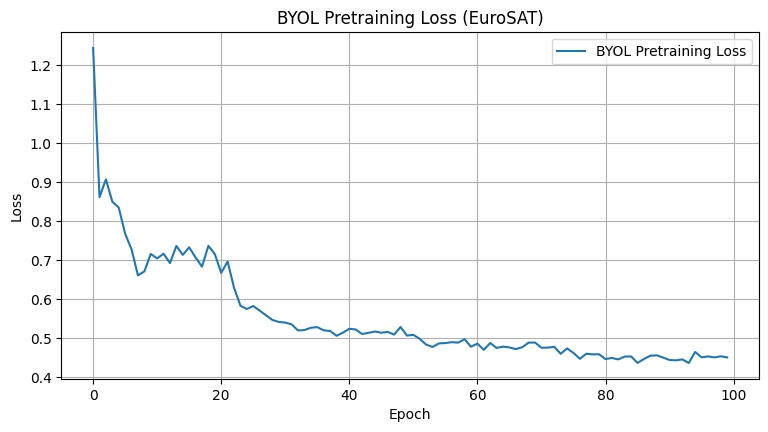

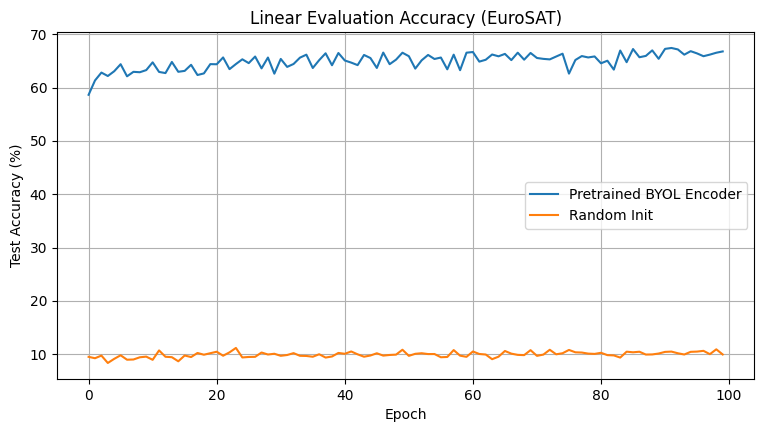


--- Running t-SNE on Encoder Embeddings ---
t-SNE input: (27000, 2048)


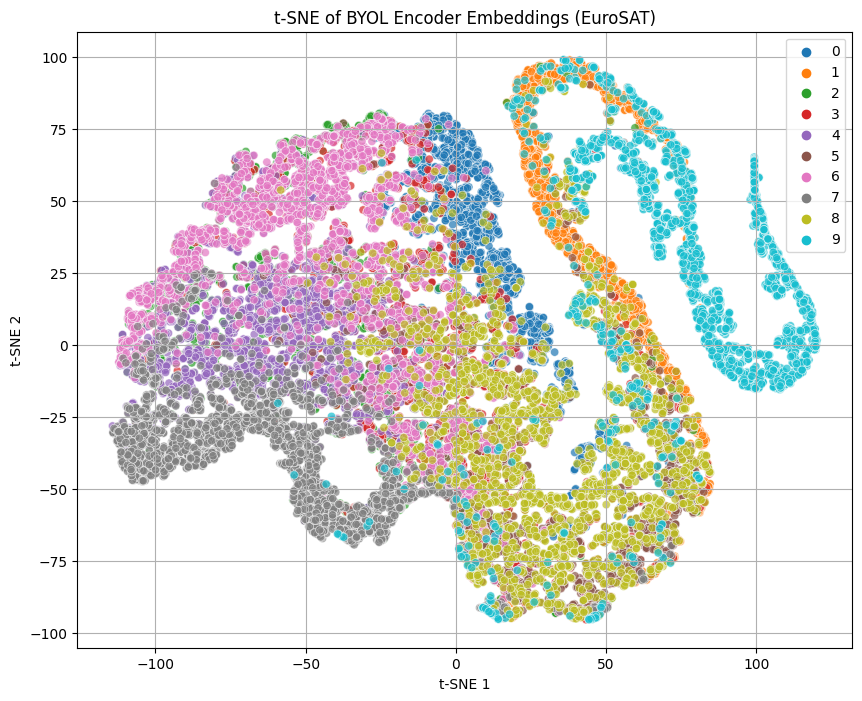

In [9]:
# =================================
# STEP 9: Visualizations
# =================================
# 9A. Pretraining loss curve
plt.figure(figsize=(9,4.5))
plt.plot(pretrain_losses, label="BYOL Pretraining Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True); plt.legend()
plt.title("BYOL Pretraining Loss (EuroSAT)")
plt.savefig(os.path.join(SAVE_DIR, "byol_pretrain_loss.png"))
plt.show()

# 9B. Linear eval accuracies
plt.figure(figsize=(9,4.5))
plt.plot(acc_pretrained, label="Pretrained BYOL Encoder")
plt.plot(acc_random, label="Random Init")
plt.xlabel("Epoch"); plt.ylabel("Test Accuracy (%)"); plt.grid(True); plt.legend()
plt.title("Linear Evaluation Accuracy (EuroSAT)")
plt.savefig(os.path.join(SAVE_DIR, "linear_eval_accuracy.png"))
plt.show()

# 9C. t-SNE (use pretrained encoder)
print("\n--- Running t-SNE on Encoder Embeddings ---")
subset_loader = DataLoader(test_dataset_eval, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
embeds, labels = [], []
with torch.no_grad():
    for imgs, lbls in subset_loader:
        imgs = imgs.to(DEVICE)
        feats = pretrained_encoder(imgs)
        embeds.append(feats.cpu().numpy())
        labels.append(lbls.numpy())
X = np.vstack(embeds); y = np.concatenate(labels)
print("t-SNE input:", X.shape)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X2 = tsne.fit_transform(X)

plt.figure(figsize=(10,8))
sns.scatterplot(x=X2[:,0], y=X2[:,1], hue=y, palette=sns.color_palette("tab10", 10),
                legend='full', alpha=0.7)
plt.title("t-SNE of BYOL Encoder Embeddings (EuroSAT)")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2"); plt.grid(True)
plt.savefig(os.path.join(SAVE_DIR, "byol_embeddings_tsne.png"))
plt.show()
